# Variable AutoEncoder

## Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np


In [2]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

x_train = np.reshape(x_train, (-1, 28 * 28))
x_test  = np.reshape(x_test,  (-1, 28 * 28))


## Sampling Layer (Reparameterization Trick)

In [3]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


## Encoder

In [4]:
latent_dim = 2  # keep small for visualization

encoder_inputs = keras.Input(shape=(784,))
x = layers.Dense(256, activation="relu")(encoder_inputs)
x = layers.Dense(128, activation="relu")(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(
    encoder_inputs, [z_mean, z_log_var, z], name="encoder"
)


## Decoder

In [5]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(128, activation="relu")(latent_inputs)
x = layers.Dense(256, activation="relu")(x)

decoder_outputs = layers.Dense(784, activation="sigmoid")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")


In [6]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # Reconstruction loss
            recon_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )

            # KL divergence
            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )

            total_loss = recon_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {
            "loss": total_loss,
            "reconstruction": recon_loss,
            "kl": kl_loss,
        }


In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

vae.fit(
    x_train,
    epochs=20,
    batch_size=128,
    validation_data=(x_test, None),
)

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# Data Loading and Preprocessing
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

x_train = np.reshape(x_train, (-1, 28 * 28))
x_test  = np.reshape(x_test,  (-1, 28 * 28))

# Sampling Layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder
latent_dim = 2

encoder_inputs = keras.Input(shape=(784,))
x = layers.Dense(256, activation="relu")(encoder_inputs)
x = layers.Dense(128, activation="relu")(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(
    encoder_inputs, [z_mean, z_log_var, z], name="encoder"
)

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(128, activation="relu")(latent_inputs)
x = layers.Dense(256, activation="relu")(x)

decoder_outputs = layers.Dense(784, activation="sigmoid")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

# VAE Model
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # Reconstruction loss
            recon_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )

            # KL divergence
            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )

            total_loss = recon_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)

        recon_loss = tf.reduce_mean(
            keras.losses.binary_crossentropy(data, reconstruction)
        )
        kl_loss = -0.5 * tf.reduce_mean(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        )
        total_loss = recon_loss + kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

if __name__ == "__main__":
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam())

    vae.fit(
        x_train,
        epochs=20,
        batch_size=128,
        validation_data=(x_test, x_test),
    )


Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - kl_loss: 0.0016 - loss: 0.2869 - reconstruction_loss: 0.2853 - val_kl_loss: 1.6937e-05 - val_loss: 0.2633 - val_reconstruction_loss: 0.2633
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - kl_loss: 4.4212e-06 - loss: 0.2634 - reconstruction_loss: 0.2634 - val_kl_loss: 9.3736e-07 - val_loss: 0.2632 - val_reconstruction_loss: 0.2632
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - kl_loss: 5.9204e-07 - loss: 0.2633 - reconstruction_loss: 0.2633 - val_kl_loss: 2.9070e-07 - val_loss: 0.2629 - val_reconstruction_loss: 0.2629
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - kl_loss: 2.1549e-07 - loss: 0.2632 - reconstruction_loss: 0.2632 - val_kl_loss: 1.6983e-07 - val_loss: 0.2629 - val_reconstruction_loss: 0.2629
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - kl_loss: 1.0724e-07 - loss: 0.2632 - reconstruction_loss: 0.2632 - val_kl_loss: 1.0204e-07 - val_loss: 0.2630 - val_reconstruction_loss: 0.2630
Epoc

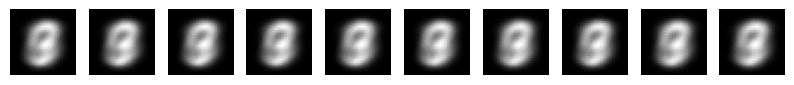

In [9]:
import matplotlib.pyplot as plt

z_samples = tf.random.normal(shape=(10, latent_dim))
generated = decoder(z_samples)

plt.figure(figsize=(10, 2))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(generated[i].numpy().reshape(28, 28), cmap="gray")
    plt.axis("off")
plt.show()